<a href="https://www.kaggle.com/code/yunusemreakca/s5e5-calories-prediction?scriptVersionId=239080683" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor

from warnings import filterwarnings
filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


# First Look

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")

In [3]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
train.shape

(750000, 9)

In [5]:
test.shape

(250000, 8)

In [6]:
train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [7]:
train.isnull().sum().sum()

0

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


# EDA

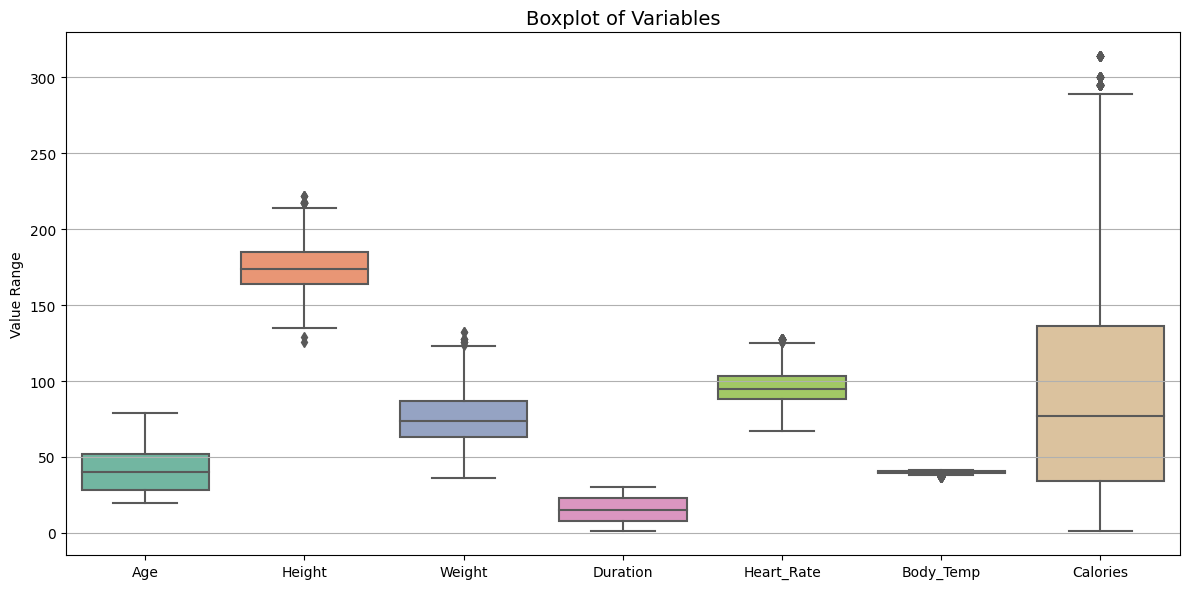

In [9]:
numeric_list = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Calories"]

melted_train = train[numeric_list].melt(var_name="Variable", value_name="Value")

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_train, x="Variable", y="Value", palette="Set2")
plt.title("Boxplot of Variables", fontsize=14)
plt.ylabel("Value Range")
plt.xlabel("")
plt.grid(axis='y')

plt.tight_layout()
plt.show()

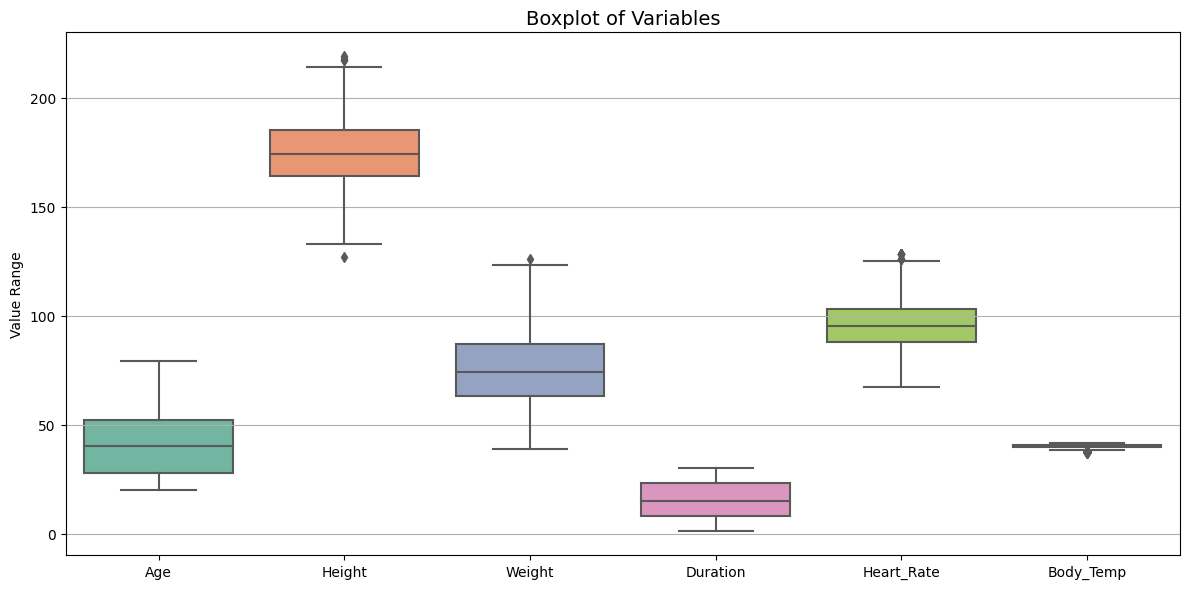

In [10]:
numeric_list = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]

melted_test = test[numeric_list].melt(var_name="Variable", value_name="Value")

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_test, x="Variable", y="Value", palette="Set2")
plt.title("Boxplot of Variables", fontsize=14)
plt.ylabel("Value Range")
plt.xlabel("")
plt.grid(axis='y')

plt.tight_layout()
plt.show()

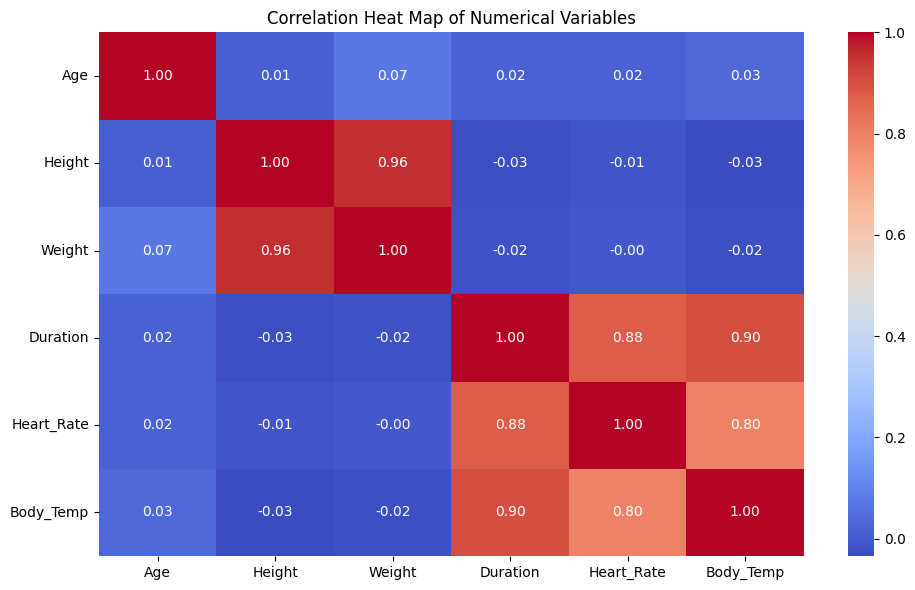

In [11]:
plt.figure(figsize=(10, 6))
corr_matrix = train[numeric_list].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heat Map of Numerical Variables")
plt.tight_layout()
plt.show()

In [12]:
train[numeric_list].corr()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
Age,1.000000,0.011975,0.073690,0.015656,0.017037,0.030275
Height,0.011975,1.000000,0.957967,-0.029936,-0.013234,-0.034641
Weight,0.073690,0.957967,1.000000,-0.020845,-0.002384,-0.023717
Duration,0.015656,-0.029936,-0.020845,1.000000,0.875327,0.903066
Heart_Rate,0.017037,-0.013234,-0.002384,0.875327,1.000000,0.795972
Body_Temp,0.030275,-0.034641,-0.023717,0.903066,0.795972,1.000000


# Outlier Dedection

In [13]:
def cap_outliers_iqr(train_df, test_df, columns):
    for col in columns:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        train_df.loc[train_df[col] > upper_limit, col] = upper_limit
        train_df.loc[train_df[col] < lower_limit, col] = lower_limit

        test_df.loc[test_df[col] > upper_limit, col] = upper_limit
        test_df.loc[test_df[col] < lower_limit, col] = lower_limit

    return train_df, test_df

In [14]:
cols = ["Height", "Weight", "Heart_Rate", "Body_Temp"]
train, test = cap_outliers_iqr(train, test, cols)

## Calories Outlier  

In [15]:
Q3 = train["Calories"].quantile(0.75)
Q1 = train["Calories"].quantile(0.25)
IQR = Q3 - Q1

Upper_limit = Q3 + 1.5 * IQR

In [16]:
outlier_upper = train["Calories"] > Upper_limit

In [17]:
train.loc[outlier_upper, "Calories"] = Upper_limit

# Feature Engineering

## Feature Creation

In [18]:
train["BMI"] = train["Weight"] / (train["Height"] / 100) ** 2
test["BMI"] = test["Weight"] / (test["Height"] / 100) ** 2

train["Effort_Score"] = train["Heart_Rate"] * train["Duration"]
test["Effort_Score"] = test["Heart_Rate"] * test["Duration"]

train["HR_per_min"] = train["Heart_Rate"] / train["Duration"]
test["HR_per_min"] = test["Heart_Rate"] / test["Duration"]

train["HeartRate_per_BodyTemp"] = train["Heart_Rate"] / train["Body_Temp"]
test["HeartRate_per_BodyTemp"] = test["Heart_Rate"] / test["Body_Temp"]

train["HR_age_ratio"] = train["Heart_Rate"] / train["Age"]
test["HR_age_ratio"] = test["Heart_Rate"] / test["Age"]

In [19]:
train["Weight_per_Height"] = train["Weight"] / train["Height"]
test["Weight_per_Height"] = test["Weight"] / test["Height"]

train["Age_BMI"] = train["Age"] * train["BMI"]
test["Age_BMI"] = test["Age"] * test["BMI"]

train["BodyTemp_Duration"] = train["Body_Temp"] * train["Duration"]
test["BodyTemp_Duration"] = test["Body_Temp"] * test["Duration"]

mean_body_temp_train = train["Body_Temp"].mean()
train["BodyTemp_Deviation"] = train["Body_Temp"] - mean_body_temp_train
mean_body_temp_test = test["Body_Temp"].mean()
test["BodyTemp_Deviation"] = test["Body_Temp"] - mean_body_temp_test

train["Max_Heart_Rate"] = 220 - train["Age"]
test["Max_Heart_Rate"] = 220 - test["Age"]
train["HeartRate_Max_HR_Ratio"] = train["Heart_Rate"] / train["Max_Heart_Rate"]
test["HeartRate_Max_HR_Ratio"] = test["Heart_Rate"] / test["Max_Heart_Rate"]

train["Effort_Score_per_Duration"] = train["Effort_Score"] / train["Duration"]
test["Effort_Score_per_Duration"] = test["Effort_Score"] / test["Duration"]

train["Weight_Age"] = train["Weight"] * train["Age"]
test["Weight_Age"] = test["Weight"] * test["Age"]

train["Weight_per_BMI"] = train["Weight"] / train["BMI"]
test["Weight_per_BMI"] = test["Weight"] / test["BMI"]

train["Exercise_Duration_Category"] = pd.cut(train["Duration"], bins=[0, 30, 60, 180], labels=["Short", "Medium", "Long"])
test["Exercise_Duration_Category"] = pd.cut(test["Duration"], bins=[0, 30, 60, 180], labels=["Short", "Medium", "Long"])

train["Age_Group"] = pd.cut(train["Age"], bins=[0, 30, 50, 100], labels=["Young", "Middle-Aged", "Old"])
test["Age_Group"] = pd.cut(test["Age"], bins=[0, 30, 50, 100], labels=["Young", "Middle-Aged", "Old"])


train["Duration_Heart_BodyTemp"] = train["Duration"] * train["Heart_Rate"] * train["Body_Temp"]
test["Duration_Heart_BodyTemp"] = test["Duration"] * test["Heart_Rate"] * test["Body_Temp"]


train["Height_Duration_BodyTemp"] = train["Height"] * train["Duration"] * train["Body_Temp"]
test["Height_Duration_BodyTemp"] = test["Height"] * test["Duration"] * test["Body_Temp"]

train["Weight_Duration_HeartRate"] = train["Weight"] * train["Duration"] * train["Heart_Rate"]
test["Weight_Duration_HeartRate"] = test["Weight"] * test["Duration"] * test["Heart_Rate"]

## Feature Scaling

In [20]:
features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Effort_Score', 
            'HR_per_min', 'HeartRate_per_BodyTemp', 'HR_age_ratio', 'Weight_per_Height', 'Age_BMI', 
            'BodyTemp_Duration', 'BodyTemp_Deviation', 'HeartRate_Max_HR_Ratio', 'Effort_Score_per_Duration', 
            'Weight_Age', 'Weight_per_BMI','Duration_Heart_BodyTemp','Height_Duration_BodyTemp','Weight_Duration_HeartRate']

In [21]:
scaler = StandardScaler()

train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

## Feature Encoding

In [22]:
label_cols = ["Exercise_Duration_Category", "Age_Group"]
le = LabelEncoder()

for col in label_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [23]:
train["Sex"] = train["Sex"].map({"male": 1, "female": 0})
test["Sex"] = test["Sex"].map({"male": 1, "female": 0})

In [24]:
train = pd.get_dummies(train, columns=["Sex", "Exercise_Duration_Category", "Age_Group"], drop_first=True)
test = pd.get_dummies(test, columns=["Sex", "Exercise_Duration_Category", "Age_Group"], drop_first=True)

In [25]:
bool_cols = train.select_dtypes("bool").columns

train[bool_cols] = train[bool_cols].astype(int)
test[bool_cols] = test[bool_cols].astype(int)

In [26]:
train.head()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Effort_Score,...,HeartRate_Max_HR_Ratio,Effort_Score_per_Duration,Weight_Age,Weight_per_BMI,Duration_Heart_BodyTemp,Height_Duration_BodyTemp,Weight_Duration_HeartRate,Sex_1,Age_Group_1,Age_Group_2
0,0,-0.357192,1.115250,0.490213,1.266324,0.583746,1.250989,150.0,-0.939030,1.163006,...,0.137830,0.583746,-0.132040,1.121197,1.183269,1.529878,1.338548,1,0,0
1,1,1.487943,-0.912146,-1.083184,-0.888309,-1.109466,-0.444352,34.0,-1.185827,-0.923978,...,0.082455,-1.109466,0.533415,-0.915861,-0.923454,-0.940327,-1.004459,0,1,0
2,2,0.631273,-1.068100,-0.797112,-1.008011,-1.215291,-0.313941,29.0,0.208832,-1.022643,...,-0.572938,-1.215291,0.101769,-1.060093,-1.017302,-1.054414,-1.046988,0,1,0
3,3,-1.411555,1.349180,1.062357,1.146622,1.007049,0.859756,140.0,0.025976,1.161934,...,-0.189837,1.007049,-0.995333,1.375607,1.161632,1.428995,1.619362,1,0,1
4,4,-0.225397,-0.678216,-1.011666,1.146622,0.689572,0.729345,146.0,-1.480924,1.081500,...,0.295772,0.689572,-0.607151,-0.696174,1.075256,0.985627,0.536003,0,0,0


# Machine Learning

In [27]:
X_train = train.drop(["id", "Calories"], axis=1)
y = train["Calories"]

X_test = test.drop(["id"],axis = 1)

## XGBoost

Best Parameters: {'n_estimators': 494, 'max_depth': 12, 'learning_rate': 0.025720450946032463, 'subsample': 0.8252835138864835, 'colsample_bytree': 0.5789286073361388, 'gamma': 1.8903496577328514, 'min_child_weight': 7, 'reg_alpha': 9.019718559862135, 'reg_lambda': 3.501605991491236}
Best RMSLE: 0.060697206984606865

In [28]:
xgb_model = XGBRegressor(subsample = 0.8252835138864835, reg_lambda = 3.501605991491236, reg_alpha= 9.019718559862135, n_estimators= 494, max_depth= 12,
learning_rate= 0.025720450946032463, gamma= 1.8903496577328514, colsample_bytree= 0.5789286073361388,min_child_weight =  7)

In [29]:
xgb_model.fit(X_train,y)
y_pred_xgb = xgb_model.predict(X_test)

In [30]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_xgb
})

submission.to_csv("submission_xgb_regression.csv", index=False)

## HistGradientBoost 

{'l2_regularization': np.float64(0.6576128923003434), 'learning_rate': np.float64(0.05783086033354717), 'max_bins': 213, 'max_depth': 13, 'max_iter': 982, 'min_samples_leaf': 86}

In [31]:
hist_model = HistGradientBoostingRegressor(l2_regularization= 0.6576128923003434, learning_rate =0.05783086033354717,max_bins= 213,max_depth = 13,max_iter= 982,min_samples_leaf= 86, random_state=42)

In [32]:
hist_model.fit(X_train,y)
y_pred_hist = hist_model.predict(X_test)

In [33]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_hist 
})

submission.to_csv("submission_hist_regression.csv", index=False)

## Ridge 

Best Ridge Params: {'alpha': 0.1, 'max_iter': 200}

In [34]:
ridge_model = Ridge(random_state=42,alpha = 0.1 , max_iter = 200)

In [35]:
ridge_model.fit(X_train,y)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_ridge_clipped = np.clip(y_pred_ridge, 0, None)

In [36]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_ridge_clipped
})

submission.to_csv("submission_ridge_regression.csv", index=False)

## Lasso 

Best Lasso Params: {'alpha': 100, 'max_iter': 200}

In [37]:
lasso_model = Lasso(random_state=42,alpha = 100 , max_iter = 200)

In [38]:
lasso_model.fit(X_train,y)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_lasso_clipped = np.clip(y_pred_lasso, 0, None)

In [39]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_lasso_clipped
})

submission.to_csv("submission_lasso_regression.csv", index=False)

## MLP

{'max_iter': 1000,'learning_rate_init': 0.0001,'hidden_layer_sizes': (64, 32),'alpha': 0.001,'activation': 'tanh'}

In [40]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64,32),
    activation="tanh",
    alpha=0.001,
    learning_rate_init=0.0001,
    max_iter=1000,
    random_state=42,
    early_stopping=True
)

mlp_model.fit(X_train, y)

y_pred = mlp_model.predict(X_test)
y_pred_mlp_clipped = np.clip(y_pred, 0, None)


In [41]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_mlp_clipped
})

submission.to_csv("submission_mlp_regression.csv", index=False)

## Light

In [42]:
params = {
    'objective': 'regression',             
    'boosting_type': 'gbdt',                
    'num_leaves': 31,                       
    'max_depth': 12,                      
    'learning_rate': 0.0257,                
    'n_estimators': 494,                    
    'subsample': 0.825,              
    'colsample_bytree': 0.579,             
    'reg_lambda': 3.50,                    
    'reg_alpha': 9.02,                 
    'min_child_weight': 7,                
    'metric': 'mse',                
    'verbosity': -1,                        
    'random_state': 42                 
}

lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train, y)

LGBMRegressor(colsample_bytree=0.579, learning_rate=0.0257, max_depth=12,
              metric='mse', min_child_weight=7, n_estimators=494,
              objective='regression', random_state=42, reg_alpha=9.02,
              reg_lambda=3.5, subsample=0.825, verbosity=-1)

In [43]:
y_pred_lgb = lgb_model.predict(X_test)
y_pred_lgb_clipped = np.clip(y_pred_lgb, 0, None)

In [44]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_lgb_clipped
})

submission.to_csv("submission_lgb_regression.csv", index=False)

## Light With Optuna

In [45]:
params = {           
    'num_leaves': 1915,                       
    'max_depth': 12,                      
    'learning_rate': 0.038721797842131186,                
    'n_estimators': 553,                    
    'subsample': 0.7107759787306983,              
    'colsample_bytree': 0.7863208714953395,             
    'reg_lambda': 0.9630375961746135,                    
    'reg_alpha': 0.025075625522452082,                 
    'min_child_samples': 97,                              
    'random_state': 42                 
}

lgb_model_optuna = lgb.LGBMRegressor(**params)
lgb_model_optuna.fit(X_train, y)

LGBMRegressor(colsample_bytree=0.7863208714953395,
              learning_rate=0.038721797842131186, max_depth=12,
              min_child_samples=97, n_estimators=553, num_leaves=1915,
              random_state=42, reg_alpha=0.025075625522452082,
              reg_lambda=0.9630375961746135, subsample=0.7107759787306983)

In [46]:
y_pred_lgb_optuna = lgb_model_optuna.predict(X_test)
y_pred_lgb_optuna_clipped = np.clip(y_pred_lgb_optuna, 0, None)

In [47]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_lgb_optuna_clipped
})

submission.to_csv("submission_lgb_optuna_regression.csv", index=False)

# Voting 

## Voting Light + XGBoost

In [48]:
voting_xgb_light = VotingRegressor(
    estimators = [
        ("xgb", xgb_model),
        ("light" , lgb_model_optuna )
    ]
)

voting_xgb_light.fit(X_train,y)

y_pred_xgb_light = voting_xgb_light.predict(X_test)
y_pred_xgb_light_clipped = np.clip(y_pred_xgb_light, 0, None)

In [49]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_xgb_light_clipped
})

submission.to_csv("submission_lgb_xgb_regression.csv", index=False)

## Voting Light + Mlp

In [50]:
voting_mlp_light = VotingRegressor(
    estimators = [
        ("mlp", mlp_model),
        ("light" , lgb_model_optuna )
    ]
)

voting_mlp_light.fit(X_train,y)

y_pred_mlp_light = voting_mlp_light.predict(X_test)
y_pred_mlp_light_clipped = np.clip(y_pred_mlp_light, 0, None)

In [51]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_mlp_light_clipped
})

submission.to_csv("submission_mlp_light_regression.csv", index=False)

## Voting Xgb + MLP

In [52]:
voting_ann_xgb = VotingRegressor(
    estimators = [
        ("ann", mlp_model),
        ("xgb" , xgb_model)
    ]
)

voting_ann_xgb.fit(X_train,y)

y_pred_ann_xgb = voting_ann_xgb.predict(X_test)
y_pred_ann_xgb_clipped = np.clip(y_pred_ann_xgb, 0, None)

In [53]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_ann_xgb_clipped
})

submission.to_csv("submission_xgb_ann_regression.csv", index=False)

## Voting Light Xgb & Light Mlp 

In [54]:
voting_lxlm = VotingRegressor(
    estimators = [
        ("lx" , voting_xgb_light),
        ("lm", voting_mlp_light)
    ]
)

voting_lxlm.fit(X_train,y)

y_pred_lxlm = voting_lxlm.predict(X_test)
y_pred_lxlm_clipped = np.clip(y_pred_lxlm, 0, None)

In [55]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_lxlm_clipped
})

submission.to_csv("submission_lxlm_regression.csv", index=False)

## Voting Light Xgb & Xgb Mlp

In [56]:
voting_lxmx = VotingRegressor(
    estimators = [
        ("lx" , voting_xgb_light),
        ("mx", voting_ann_xgb)
    ]
)

voting_lxmx.fit(X_train,y)

y_pred_lxmx = voting_lxmx.predict(X_test)
y_pred_lxmx_clipped = np.clip(y_pred_lxmx, 0, None)

In [57]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_lxmx_clipped
})

submission.to_csv("submission_lxmx_regression.csv", index=False)

## Voting Xgb Mlp & Light Mlp

In [58]:
voting_lmxm = VotingRegressor(
    estimators = [
        ("lm" , voting_mlp_light),
        ("xm", voting_ann_xgb)
    ]
)

voting_lmxm.fit(X_train,y)

y_pred_lmxm = voting_lmxm.predict(X_test)
y_pred_lmxm_clipped = np.clip(y_pred_lmxm, 0, None)

In [59]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred_lmxm_clipped
})

submission.to_csv("submission_lmxm_regression.csv", index=False)